In [19]:
import os.path
import glob
import torch
from torch_geometric.loader import DataLoader
from pointcloud_dataloader import PointCloudsInFiles
from matplotlib import pyplot as plt
import sklearn.metrics as metrics
from math import sqrt
import numpy as np
from pointcloud_dataloader import read_las
from itertools import compress
from pathlib import Path
import pandas as pd
from random import sample

# Apply the model to the test dataset and plot the results --------------------------------------------------

# Select a model to use:
model_file = None

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Specify model params
use_columns = ['intensity_normalized']
use_datasets = ["BC"]  # Possible datasets: BC, RM, PF
num_points = 7_000
test_dataset_path = r'D:\Sync\Data\Model_Input\test'

# Load most recent model
if model_file is None:
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.model'
    files = glob.glob(folder_path + file_type)
    model_file = max(files, key=os.path.getctime)
    model = torch.load(model_file)
else:
    model = torch.load(model_file)
print("Using model:", model_file)

# Get test data
test_dataset = PointCloudsInFiles(test_dataset_path, '*.las', max_points=num_points, use_columns=use_columns,
                                  filter_height=0.2, dataset=use_datasets)

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Apply the model
model.eval()
for idx, data in enumerate(test_loader):
    data = data.to(device)
pred = model(data)[:, 0].to('cpu').detach().numpy()
obs = data.y.to('cpu').detach().numpy()

# Calculate R^2 and RMSE for test dataset
test_r2 = round(metrics.r2_score(obs, pred), 3)
test_rmse = round(sqrt(metrics.mean_squared_error(obs, pred)), 2)
print(f"R2: {test_r2}\nRMSE: {test_rmse}")

# Get residuals
resid = obs - pred

# Plot observed vs. predicted
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(obs, pred)
ax1.set(xlabel='Observed Biomass (Tons)', ylabel='Predicted Biomass (Tons)')
plt.figtext(0.1, 0.65, f"R2: {test_r2}\nRMSE: {test_rmse}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax1.transAxes)

# Plot residuals
ax2.scatter(pred, resid)
ax2.set(xlabel='Predicted Biomass (Tons)', ylabel='Residuals')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)
plt.show()



Using model: D:\Sync\DL_Development\Models\DL_model_2022_07_20_16_32_21.model


AttributeError: 'GlobalStorage' object has no attribute 'plotID'

In [15]:
plotID


NameError: name 'plotID' is not defined

In [ ]:
# Visualize point clouds of four random plots with estimated and observed biomass provided  ---------------------------------------------------------------------------------

#Create a df with observed/predicted biomass and PlotID
df = pd.DataFrame(list(zip(obs, pred, data.PlotID)),
                      columns=['point_num', 'val_mse', 'runtime'])


In [5]:
# Visualize point clouds of four random plots with estimated and observed biomass provided  ---------------------------------------------------------------------------------

#Get all the LAS files in the test dataset (that belong to the use dataset(s))
# List files
glob='*'
files = list(Path(test_dataset_path).glob(glob))
# Get dataset source for each LAS file
dataset_ID = []
for i in range(0, len(files), 1):
    dataset_ID.append(files[i].name.split(".")[0][0:2])
# Convert to pandas series
dataset_ID = pd.Series(dataset_ID, dtype=str)
# Determine whether or not to keep each file based on dataset ID
dataset_filter = dataset_ID.isin(use_datasets).tolist()
# Filter files to target dataset(s)
files = list(compress(files, dataset_filter))
#Randomly select 4 files from the list
sample_idxs = sample(list(range(0, len(files), 1)), 4)
print(sample_idxs)
#Subset files
files_sample = [files[i] for i in sample_idxs]
print(files[2])
print(files_sample[sample_idxs[2]])

[16, 12, 1, 7]
D:\Sync\Data\Model_Input\test\BCGOV132.las
D:\Sync\Data\Model_Input\test\BCGOV40.las


In [11]:
PlotIDs = []
for i in range(0, len(files), 1):
    PlotIDs.append(os.path.basename(files[i]))


print(pred)
print(obs)
print(PlotIDs)

[ 4.0812445   1.3225194   0.86144775  9.504472   20.677916    7.57275
 -0.06542601  6.538347    7.7424417   7.3955407   2.1016963   1.290582
  1.5253767   0.37341505  1.5685632   3.2581086   6.6890254   4.1627164 ]
[1.41962204e+01 1.24450741e+01 5.84360552e+00 1.61454697e+01
 6.56986542e+01 2.21887798e+01 4.78925593e-02 1.70003510e+01
 4.80951357e+00 3.08424339e+01 8.39813900e+00 4.87214756e+00
 4.89254761e+00 1.81147206e+00 5.96220398e+00 1.17665768e+01
 1.65456238e+01 1.21735115e+01]
['BCGOV132.las', 'BCGOV_P103.las', 'BCGOV_P105.las', 'BCGOV167.las']


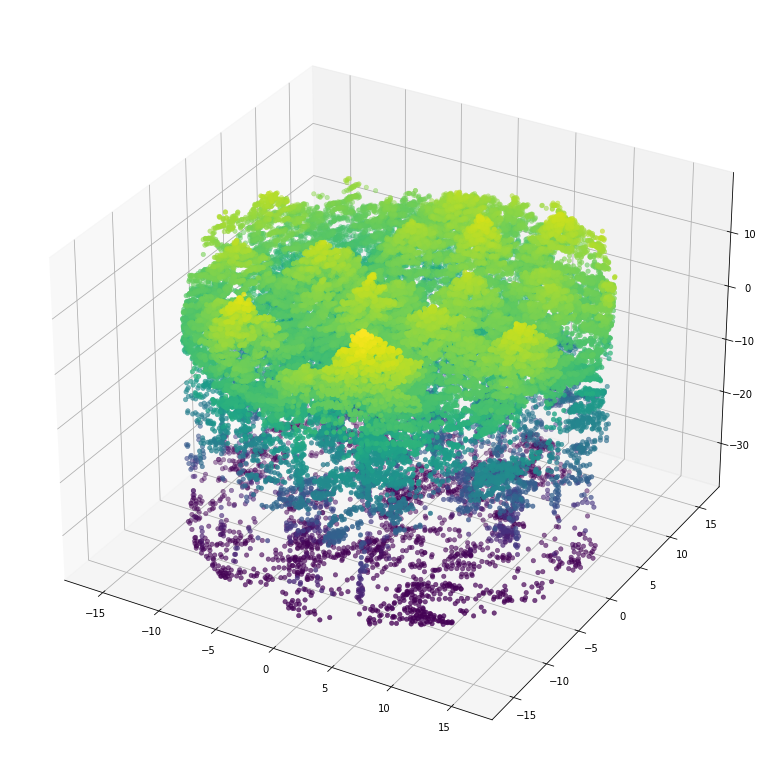

In [11]:
#Load coords for each LAS
coords, _ = read_las(files[1], get_attributes=True)

# Resample number of points to num_points
if coords.shape[0] >= num_points:
    use_idx = np.random.choice(coords.shape[0], num_points, replace=False)
else:
    use_idx = np.random.choice(coords.shape[0], num_points, replace=True)

# centralize coordinates
coords = coords - np.mean(coords, axis=0)



In [ ]:
#Set axis variables for plotting
x = coords[:, 0]
y = coords[:, 1]
z = coords[:, 2]

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=[30, 30])

# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)

plt.show()